In [72]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spotify-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1800580%2F2936818%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T124252Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9773e10b6caa4f5e3a2d28542f6b98221bc908875cca19e8d55d4d6359eac4712e175e5b404069246a68067eea448e3b6ef94381ef5eabc4c3248cf55aed51bf37ab20d4083e0d7dc20bc0d98b7c3df63f78926b53a0c5685848b1dcb7ecd4127ac110a0b1c5cd7b7e3051c0cb4ae127378965f6e5f4162fc4ea0700a8f64e86e5a371ae84bad554c694d6b566a0addbf7b2bf34dd69fff75f20a3a33b471717ce823315960f87e72ae7956eaf9d8bd94f355fb7f243a589556bc09a908fe9054b3f5026dcaae117afd102a638e79a086a626f18bf854c8ec313691e8049168c160574960188b54958f470cb07c8417bf6ddf7576c9c6377b6547bd294d57645,-spotify-tracks-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2570056%2F4372070%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T124252Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e3bfbdc26215b13bc1ffeafa1395e029615bf9c8a822f927be8b4a60822d4c09df5338765935e201a053efeca40facd52a9a0440dc3b625bda27fea690989ea414d3719b3369141a2220f9c6b96a0a4d9efb3b3479606164333967433cb27aae549afdf251719484441e8812d13a2504153184e828c75325e18331791177f2695e734b182372176d54ae5cce6732e964451f44fc34a13892aff33cd18efe55d5691904c652dcef1943a783ad23658586cb664044e612c3db57fba08fbe0b8c84d9f564141f6f65180e12930d5217a8bfc80c409a5e857df94d3c3731dc1c849809fd5407549dc42ca31e8df2ec6a4e35517fa2d99b955d02496d572842f3f20'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17275602 bytes downloaded
Downloaded and uncompressed: spotify-dataset
[==================================================] 8571542 bytes downloaded
Downloaded and uncompressed: -spotify-tracks-dataset
Data source import complete.


# Import Library and Dataset

In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers


import warnings
warnings.filterwarnings('ignore')

In [74]:
#Main Raw Dataframe
df = pd.read_csv("/kaggle/input/-spotify-tracks-dataset/dataset.csv")
df.drop(columns='Unnamed: 0',inplace=True)

#Dataframe for getting year feature of songs
dfYear = pd.read_csv("/kaggle/input/spotify-dataset/data/data.csv")
dfYear = dfYear[['id','year']]
dfYear['track_id'] = dfYear['id']
dfYear.drop(columns='id',inplace=True)

#Merge 2 Dataframe
df = pd.merge(df,dfYear,on='track_id')
display(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9654 entries, 0 to 9653
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          9654 non-null   object 
 1   artists           9654 non-null   object 
 2   album_name        9654 non-null   object 
 3   track_name        9654 non-null   object 
 4   popularity        9654 non-null   int64  
 5   duration_ms       9654 non-null   int64  
 6   explicit          9654 non-null   bool   
 7   danceability      9654 non-null   float64
 8   energy            9654 non-null   float64
 9   key               9654 non-null   int64  
 10  loudness          9654 non-null   float64
 11  mode              9654 non-null   int64  
 12  speechiness       9654 non-null   float64
 13  acousticness      9654 non-null   float64
 14  instrumentalness  9654 non-null   float64
 15  liveness          9654 non-null   float64
 16  valence           9654 non-null   float64


None

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,year
0,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.905,0.000071,0.1320,0.1430,181.740,3,acoustic,2018
1,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.469,0.000000,0.0829,0.1670,119.949,4,acoustic,2017
2,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,acoustic,2014
3,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,piano,2014
4,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.559,0.000000,0.0973,0.7120,150.960,4,acoustic,2008


In [75]:
# Duplicate Check
df[df.duplicated('track_id')==True]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,year
3,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.147,2,...,1,0.0355,0.85700,0.000003,0.0913,0.0765,141.284,3,piano,2014
5,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.444,11,...,1,0.0417,0.55900,0.000000,0.0973,0.7120,150.960,4,rock,2008
8,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.632,1,...,1,0.0295,0.42600,0.004190,0.0735,0.1960,78.899,4,piano,2015
11,3ILmwMefYZoQh5Cf5jeuUQ,Motohiro Hata,Documentary,透明だった世界,61,232360,False,0.373,0.914,0,...,1,0.0565,0.07600,0.000000,0.6690,0.5600,168.210,4,j-pop,2010
12,3ILmwMefYZoQh5Cf5jeuUQ,Motohiro Hata,Documentary,透明だった世界,61,232360,False,0.373,0.914,0,...,1,0.0565,0.07600,0.000000,0.6690,0.5600,168.210,4,j-rock,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9227,1TIiWomS4i0Ikaf9EKdcLn,Tove Lo,BLUE LIPS (lady wood phase II),disco tits,64,223794,True,0.790,0.728,7,...,1,0.0612,0.02500,0.001060,0.1720,0.3330,110.059,4,synth-pop,2017
9236,6MDijuuArPJv1vbp7K1x3f,Miike Snow,iii,Genghis Khan,62,212146,False,0.688,0.847,10,...,0,0.0508,0.04000,0.000003,0.5980,0.4530,93.979,4,synth-pop,2016
9242,3VZQshi4COChhXaz7cLP02,Icona Pop;Charli XCX,I Love It (feat. Charli XCX),I Love It (feat. Charli XCX),63,155337,True,0.714,0.905,8,...,1,0.0289,0.00855,0.000025,0.1460,0.8380,125.927,4,synth-pop,2012
9420,1CgbwsrNDlFrRuk2ebQ7zr,ATB,Movin' Melodies,9Pm (Till I Come),64,193880,False,0.672,0.941,9,...,0,0.0494,0.02760,0.926000,0.1490,0.7540,130.218,4,trance,1999


In [76]:
df[df['track_id']=='6Vc5wAMmXdKIAM7WUoEb7N']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,year
2,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.147,2,...,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,acoustic,2014
3,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.147,2,...,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,piano,2014


Duplicate data happened because of the song has 2 or more genres.

# Pre-Processing

## Genre Encoding

Data encoded by using Cross Tabulation

In [77]:
# Crosstab Genre and Song

xtab_song = pd.crosstab(
    df['track_id'],
    df['track_genre']
)

xtab_song = xtab_song*2

display(xtab_song.head(),len(xtab_song))

track_genre,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,brazil,...,soul,spanish,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
track_id,,,,,,,,,,,,,,,,,,,,,
003vvx7Niy0yvhvHt4a68B,0,0,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00KfIFi2TpAaQGPbRbFbKJ,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00Y9r5SfbDdEjJhNg7laQr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00hTMcTeaaMtjBCV30yAm9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00iwQgjIgoGO94BRBDyClo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


6788

In [78]:
# Concatenate the encoded genre columns with the original dataframe

dfDistinct = df.drop_duplicates('track_id')
dfDistinct = dfDistinct.sort_values('track_id')
dfDistinct = dfDistinct.reset_index(drop=True)

xtab_song.reset_index(inplace=True)
data_encoded = pd.concat([dfDistinct, xtab_song], axis=1)
display(data_encoded.head(),len(data_encoded))

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,soul,spanish,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,...,0,0,0,0,0,0,0,0,0,0
1,00KfIFi2TpAaQGPbRbFbKJ,Linkin Park,LIVING THINGS,IN MY REMAINS,63,200693,False,0.553,0.907,9,...,0,0,0,0,0,0,0,0,0,0
2,00Y9r5SfbDdEjJhNg7laQr,Harold Faltermeyer;Steve Stevens,Top Gun - Motion Picture Soundtrack (Special E...,"Top Gun Anthem - From ""Top Gun"" Original Sound...",62,252200,False,0.423,0.651,0,...,0,0,0,0,0,0,0,0,0,0
3,00hTMcTeaaMtjBCV30yAm9,"Bobby Cruz;Ricardo ""Richie"" Ray",Felices Pascuas,Aguinaldo Navideño,27,253506,False,0.638,0.667,7,...,0,0,0,0,0,0,0,0,0,0
4,00iwQgjIgoGO94BRBDyClo,Kudasaibeats,Falling,The Girl I Haven't Met,56,195000,False,0.785,0.222,8,...,0,0,0,0,0,0,0,0,0,0


6788

## Scaling Numerical Features

In [79]:
numerical_features = ['duration_ms','tempo', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence','year', 'popularity']
scaler = MinMaxScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
display(data_encoded)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,soul,spanish,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,0.914634,0.125678,0.0,0.359184,0.910998,1,...,0,0,0,0,0,0,0,0,0,0
1,00KfIFi2TpAaQGPbRbFbKJ,Linkin Park,LIVING THINGS,IN MY REMAINS,0.634146,0.111120,0.0,0.564286,0.906998,9,...,0,0,0,0,0,0,0,0,0,0
2,00Y9r5SfbDdEjJhNg7laQr,Harold Faltermeyer;Steve Stevens,Top Gun - Motion Picture Soundtrack (Special E...,"Top Gun Anthem - From ""Top Gun"" Original Sound...",0.621951,0.144774,0.0,0.431633,0.650993,0,...,0,0,0,0,0,0,0,0,0,0
3,00hTMcTeaaMtjBCV30yAm9,"Bobby Cruz;Ricardo ""Richie"" Ray",Felices Pascuas,Aguinaldo Navideño,0.195122,0.145627,0.0,0.651020,0.666993,7,...,0,0,0,0,0,0,0,0,0,0
4,00iwQgjIgoGO94BRBDyClo,Kudasaibeats,Falling,The Girl I Haven't Met,0.548780,0.107401,0.0,0.801020,0.221984,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,7zr6d9QDDmpo0w0N5LPBjs,Thievery Corporation,Sounds From The Thievery Hi-Fi,Shaolin Satellite,0.463415,0.231289,0.0,0.785714,0.572991,0,...,0,0,0,0,0,0,0,2,0,0
6784,7zrpoAJte9o12TzawqgdD0,Andrea Bocelli,Bocelli (Remastered),Con te partirò,0.682927,0.143979,0.0,0.245918,0.366987,7,...,0,0,0,0,0,0,0,0,0,0
6785,7zscdQe9CjzXnqT3P1Ey7K,AC/DC,Highway to Hell,If You Want Blood (You've Got It),0.634146,0.159165,0.0,0.496939,0.931999,2,...,0,0,0,0,0,0,0,0,0,0
6786,7zsw78LtXUD7JfEwH64HK2,Pat Carroll;Disney,The Little Mermaid Special Edition,Poor Unfortunate Souls,0.634146,0.170578,0.0,0.391837,0.179984,0,...,0,0,0,0,0,0,0,0,0,0



# Similarity Calculation

In [80]:
# Select the relevant columns for computing item similarities
calculatied_features = numerical_features + list(xtab_song.drop(columns='track_id').columns)

cosine_sim = cosine_similarity(data_encoded[calculatied_features], data_encoded[calculatied_features])
display(cosine_sim)

array([[1.        , 0.47941598, 0.28447436, ..., 0.31111817, 0.23527954,
        0.99376982],
       [0.47941598, 1.        , 0.28211997, ..., 0.31529413, 0.24104554,
        0.48652359],
       [0.28447436, 0.28211997, 1.        , ..., 0.40410166, 0.30992474,
        0.29393991],
       ...,
       [0.31111817, 0.31529413, 0.40410166, ..., 1.        , 0.33065776,
        0.31697487],
       [0.23527954, 0.24104554, 0.30992474, ..., 0.33065776, 1.        ,
        0.26320927],
       [0.99376982, 0.48652359, 0.29393991, ..., 0.31697487, 0.26320927,
        1.        ]])

# Model Training

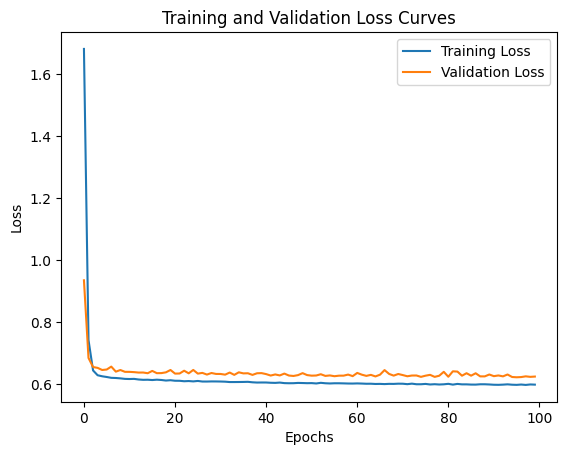

43/43 [==============================] - 0s 2ms/step
Accuracy: 0.678939617083947


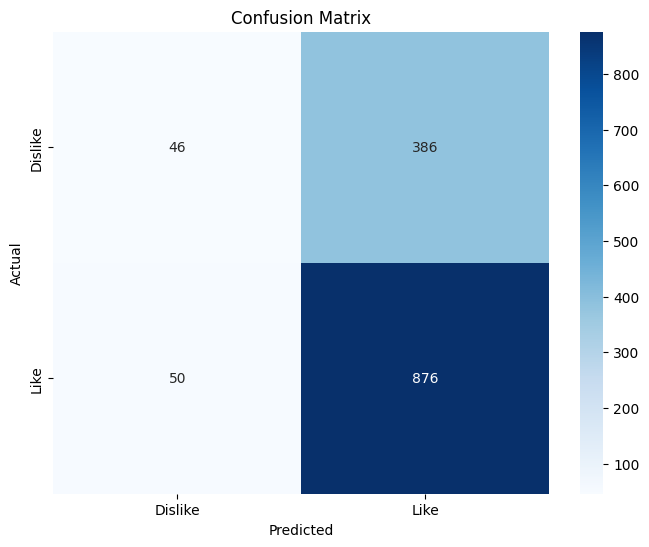

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.11      0.17       432
           1       0.69      0.95      0.80       926

    accuracy                           0.68      1358
   macro avg       0.59      0.53      0.49      1358
weighted avg       0.63      0.68      0.60      1358



In [90]:
# Train-test split
X = data_encoded[calculatied_features]
y = data_encoded['mode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model with L2 regularization
model = tf.keras.models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Dislike', 'Like'], yticklabels=['Dislike', 'Like'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Output

## Output Function

In [82]:
def get_recommendations(title, N=5):
    indices = pd.Series(data_encoded.index, index=data_encoded['track_name']).drop_duplicates()

    try:
        idx = indices[title]
        try:
            len(idx)
            temp = 2
        except:
            temp = 1
    except KeyError:
        return "Song not found in the dataset."

    if temp == 2:
        idx = indices[title][0]
    else:
        idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    song_indices = [i[0] for i in sim_scores]
    recommended_songs = data_encoded[['track_name', 'artists', 'album_name']].iloc[song_indices]

    sim_scores_list = [i[1] for i in sim_scores]
    recommended_list = recommended_songs.to_dict(orient='records')
    for i, song in enumerate(recommended_list):
        song['similarity_score'] = sim_scores_list[i]

    return recommended_list

## Input and Recommendation Output

In [83]:
# Get the recommendations
recommended_songs = get_recommendations("Mr. Brightside", N=10)
if isinstance(recommended_songs, str):
    print(recommended_songs)
else:
    print("Recommended Songs:")
    for song in recommended_songs:
        print(f"Title: {song['track_name']}")
        print(f"Artist: {song['artists']}")
        print(f"Album: {song['album_name']}")
        print(f"Similarity Score: {song['similarity_score']:.2f}")
        print()



Recommended Songs:
Title: The Beach
Artist: The Neighbourhood
Album: Wiped Out!
Similarity Score: 1.00

Title: You Get Me So High
Artist: The Neighbourhood
Album: Hard To Imagine The Neighbourhood Ever Changing
Similarity Score: 0.99

Title: Renegades
Artist: X Ambassadors
Album: VHS
Similarity Score: 0.99

Title: Shut Up and Dance
Artist: WALK THE MOON
Album: TALKING IS HARD
Similarity Score: 0.99

Title: Legend
Artist: The Score
Album: ATLAS
Similarity Score: 0.99

Title: Unstoppable
Artist: The Score
Album: ATLAS
Similarity Score: 0.99

Title: Softcore
Artist: The Neighbourhood
Album: Hard To Imagine The Neighbourhood Ever Changing
Similarity Score: 0.99

Title: Revolution
Artist: The Score
Album: ATLAS
Similarity Score: 0.99

Title: Born For This
Artist: The Score
Album: Pressure
Similarity Score: 0.99

Title: Daddy Issues
Artist: The Neighbourhood
Album: Wiped Out!
Similarity Score: 0.99

